# COVID-19 Literature search using pre-trained GloVe word vectors  
**Steps:**  
**1) Load data into DataFrame.  
2) Work on a slice of DataFrame for the experiment.  
3) Clean the body text.  
4) Filter articles which are in English and remove those which are likely noise.  
5) Load the pre-trained GloVe vectors.  
6) Tokenize the body text to get tokens and their frequency.  
7) Get document embedding for each document by averaging over word embeddings for all the filtered words in the article and store those in a matrix.  
8) Get the norm of each document embedding and store that in a vector.  
9) Get the keywords from the question after tokenizing the question.  
10) Get the keywords embedding by averaging over word embeddings for all keywords and store that in a vector.  
11) Get the norm of keywords embedding.  
12) Compute the cosine similarity using matrix vector multiplication and norms of document embeddings and keyword embeddings.  
13) Get the top 5 articles that have the highest cosine similarity with the keywords of the question.**  

Preprocessing and loading the data taken from notebook: COVID EDA: Initial Exploration Tool, by Ivan Ega Pratama
https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

Import Modules

In [1]:
import numpy as np 
import pandas as pd
import glob
import json
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter

from tqdm import tqdm
!pip install langdetect
from langdetect import detect

     |████████████████████████████████| 981 kB 4.6 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=35636333ad85fc14c7cc75c032d86131c7dc59dedce3e769ea02547fe67a27e2
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Loading Data

Loading all json files

In [2]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
all_json = glob.glob(f'{root_path}document_parses/**/*.json', recursive=True)
print('Total number of papers : {}'.format(len(all_json)))

Total number of papers : 109431


Helper class for reading json file
* Input : Path to json file
* Use : Reads and stores title, body_text, authors, etc about paper

In [3]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.title = content['metadata']['title']
            self.authors = ''
            for author in content['metadata']['authors']:
                #concatenate first name and last name
                self.authors += author['first'] + ' ' + author['last'] + ", "
            #removing last comma and a space from string authors
            self.authors = self.authors[:-2]
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except:
                self.abstract = []
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            #converting list to string
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

    
# first_row = FileReader(all_json[0])
# print(first_row)

Function to read all json files one by one and store in pandas dataframe

In [4]:
def read_dataset(all_json):
    dict_ = {'paper_id': [],  'title': [], 'authors': [], 'abstract': [], 'body_text': []}
    for idx, entry in enumerate(tqdm(all_json)):
#         if idx % (len(all_json) // 10) == 0:
#             print(f'Processing index: {idx} of {len(all_json)}')
        content = FileReader(entry)
        dict_['paper_id'].append(content.paper_id)
        dict_['title'].append(content.title)
        dict_['authors'].append(content.authors)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)
    df_dataset = pd.DataFrame(dict_, columns=['paper_id', 'title', 'authors', 'abstract', 'body_text'])
    return df_dataset

Read all files

In [5]:
df_covid = read_dataset(all_json[:15000])
df_covid.head()

100%|██████████| 15000/15000 [00:57<00:00, 259.26it/s]


,paper_id,title,authors,abstract,body_text
0,a08629ffb6fc1b030dfbaa4f1a3e233e1e9b76d9,Membrane Biology Preferred Apical Distribution...,"Michael Lisanti, Andr6 Le Bivic, Alan Saltielt...",We use a sensitive biotin polarity assay to su...,The conventional mechanism by which glycoprore...
1,f2638c7eb97ffdb517aa05fc26353f1af3cd8305,Facing COVID-19 in the ICU: vascular dysfuncti...,"Daniel Leisman, Clifford Deutschman, Matthieu ...",,"Published data [1, 2] , anecdotal observations..."
2,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,"Mathias Cousin, Nicolas Molinari, Vincent Foul...",,Despite conventional management with antibioti...
3,e668cd173db14ab973db135bc4fdb6f954e1515c,Disparities in the Population at Risk of Sever...,"Matthew Raifman, Julia Scd, Julia Raifman",,Identifying those at heightened risk of severe...
4,eb1cc7c78d58eee6f6f81092426a9a5c9aab696c,,,,evolved to respiratory and renal failure (with...


# Preprocess Data

Function to clean dataset
* Input : Dataframe
* Output : Dataframe with no duplicates and null values

In [6]:
def dataset_cleanup(df_dataset):
    print("Cleaning Dataset")
    try:
        df_dataset.drop_duplicates(['abstract', 'filtered_body_text'], inplace=True)
    except:
        df_dataset.drop_duplicates(['abstract', 'body_text'], inplace=True)
    df_dataset.dropna(inplace=True)
    return df_dataset

Function to filter body text
* Input : Dataframe
* Output : Dataframe with only lower cased plain text as 'filtered_body_text'


1. removes content in [] and ()
2. removes \n and \t
3. removes extra spaces
4. keeps only alphanumeric characters
5. makes all lower case

In [7]:
def text_filtering(df_dataset):
    df_dataset['filtered_body_text'] = df_dataset['body_text'].copy()# change this back to body-text
    #remove square bracket contents
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\[.*?\]','',x))
    print('square bracket contents removal done')
    #remove parenthesis contents
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\(.*?\)','',x))
    print('parenthesis contents removal done')
    #remove punctuation except hyphen
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s-]','',x))
    print('punctuation removal done')
    #remove \n \t
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\n|\t',' ',x))
    print('\\n \\t removal done')
    #remove extra space
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub(' +',' ',x))
    print('extra space removal done')
#     remove non alpha numeric
#     df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: "".join(filter(str.isalnum, x)))
#     print('non alpha numeric removal done')
    # make everything lower case
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: x.lower())
    print('everything made lowercase')
    return df_dataset

Function to filter only english papers
* Input : Dataframe
* Output : Dataframe with only english papers


Checks if word 'the' is present in the paper
* If No : the peper is mostly not from english

In [8]:
def filter_english(df_dataset, show_ignored=False):
    print("Filtering English Documents")
    ignore_idxs = []
    for i in tqdm(range(df_dataset.shape[0])):
        try:
            if not detect(df_dataset.iloc[i]['filtered_body_text'][:]) == "en":
                ignore_idxs.append(i)
        except:
            ignore_idxs.append(i)

#     for i in range(df_dataset.shape[0]):
#         if ' the ' not in df_dataset.iloc[i]['filtered_body_text']:
#             ignore_idxs.append(i)
    
    if show_ignored:
        for i in ignore_idxs[:10]:
            print (df_dataset.iloc[i]['filtered_body_text'][:250]+"......")
            print("="*140)
            
    df_dataset.drop(df_dataset.index[ignore_idxs], inplace=True)
    return df_dataset

Function to remove small papers
* Input : Dataframe
* Output : Dataframe with only papers with more than 500 letters in them.


If paper has less than 500 letters then it is mostly comments or random text.

In [9]:
def remove_small_papers(df_dataset, show_ignored=False):
    ignore_idxs = []
    for i in tqdm(range(df_dataset.shape[0])):
        if len(df_covid_small.iloc[i]['filtered_body_text']) < 500:
                ignore_idxs.append(i)
    if show_ignored:
        for i in ignore_idxs[:10]:
            print (df_dataset.iloc[i]['filtered_body_text'][:250]+"......")
            print("="*140)
    df_dataset.drop(df_dataset.index[ignore_idxs], inplace=True)
    return df_dataset

In [10]:
df_covid = dataset_cleanup(df_covid)
df_covid.info()

Cleaning Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14924 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   14924 non-null  object
 1   title      14924 non-null  object
 2   authors    14924 non-null  object
 3   abstract   14924 non-null  object
 4   body_text  14924 non-null  object
dtypes: object(5)
memory usage: 699.6+ KB


In [11]:
df_covid_small = df_covid.head(10000).copy()
# df_covid_small = df_covid.copy()

In [12]:
df_covid_small = text_filtering(df_covid_small)
df_covid_small = dataset_cleanup(df_covid_small)
df_covid_small = remove_small_papers(df_covid_small)
df_covid_small = filter_english(df_covid_small)
df_covid_small = dataset_cleanup(df_covid_small)

square bracket contents removal done
parenthesis contents removal done
punctuation removal done
\n \t removal done
extra space removal done
everything made lowercase
Cleaning Dataset


  0%|          | 0/9930 [00:00<?, ?it/s]

Filtering English Documents


100%|██████████| 9930/9930 [11:32<00:00, 14.35it/s]


Cleaning Dataset


In [13]:
df_covid_small.info()
print(df_covid_small)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9551 entries, 0 to 10030
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   paper_id            9551 non-null   object
 1   title               9551 non-null   object
 2   authors             9551 non-null   object
 3   abstract            9551 non-null   object
 4   body_text           9551 non-null   object
 5   filtered_body_text  9551 non-null   object
dtypes: object(6)
memory usage: 522.3+ KB
                                       paper_id  \
0      a08629ffb6fc1b030dfbaa4f1a3e233e1e9b76d9   
1      f2638c7eb97ffdb517aa05fc26353f1af3cd8305   
2      71ff6abe3023a4c48fd6e6c54265bce395b88397   
3      e668cd173db14ab973db135bc4fdb6f954e1515c   
4      eb1cc7c78d58eee6f6f81092426a9a5c9aab696c   
...                                         ...   
10026  4de66808e17dc7e6b9b5830eb1c6391af86aa4c3   
10027  31444d7f1ab91c135915a78182b26f5df3ca1048   
10028  a

# Apply Glove Vectors

Customize_stop_words taken from notebook: Topic Modeling: Finding Related Articles, by Daniel Wolffram https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

In [14]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]
final_stop_words = set(stopwords.words('english')).union(STOP_WORDS).union(set(customize_stop_words))

In [15]:
#From coursera course on sequence models
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map

root_path = '/kaggle/input/glove6b100d'
word_to_vec_map = read_glove_vecs(f'{root_path}/glove.6B.100d.txt')

Function words_freq_atleast_2 which will take a body text and returns a list containing only those words and their frequency which have frequency greater than one.
* Input : Filtered body text
* Output : List of words with frequency atleast 2


In [19]:
def words_freq_atleast_2(filtered_body_text):
    #tokenize the text
    tokens = nltk.word_tokenize(filtered_body_text)
    #print(tokens)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    #print(tokens[:5])
    return list(filter(lambda x: x[1] != 1, Counter(tokens).most_common()))

words_freq_atleast_2(df_covid_small.iloc[1]['filtered_body_text'])[:5]

[('angii', 17),
 ('covid-19', 15),
 ('endothelial', 13),
 ('patient', 11),
 ('vascular', 9)]

Function doc_to_vec to get vectors of the documents
* Input : document text
* Output : vector of length 100

Get the embeddings for each word returned by the function words_freq_atleast_2, add them and then compute average to get the embeddings for the document.

In [20]:
def doc_to_vec(doc_text):
    words_freq = words_freq_atleast_2(doc_text)
    doc_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    num_words = 0
    for word_freq in words_freq:
        word = word_freq[0]
        freq = word_freq[1]
        try:
            #adding word embeddings for each word in the document
            doc_embedding_vec += (word_to_vec_map[word] * freq)
            num_words += freq
        except:
            continue
    if num_words != 0:
        # doing average
        doc_embedding_vec /= num_words
    else:
        doc_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    
#     print(np.isnan(doc_embedding_vec).any())
    return [doc_embedding_vec, not (np.isnan(doc_embedding_vec).any())]

Function dataset_to_vectors to convert whole dataset into multiple vectors
* Input : dataframe
* Output : array of vectors one for each document

In [21]:
def dataset_to_vectors(ds):
    doc_embeddings = np.zeros((len(ds),100))
    for i in tqdm(range(len(ds))):
#         if i % 1000 == 0:
#             print("working on "+str(i)+"th document of "+str(len(ds))+" documents...")
        doc_embedding_vec, hit = doc_to_vec(ds.iloc[i]['filtered_body_text'])
        if not hit:
            print("No word in document {} as vector in glove".format(i))
        doc_embeddings[i,:] = doc_embedding_vec
    return doc_embeddings

In [22]:
doc_embeddings = dataset_to_vectors(df_covid_small)

100%|██████████| 9551/9551 [10:34<00:00, 15.06it/s]  


In [23]:
print(doc_embeddings.shape)

(9551, 100)


Define a function get_kw_embedding_vec which takes as input keywords from the question and returns keyword embedding vectors.

In [16]:
def get_kw_embedding_vec(key_words):
    #key_words=['virus', 'genetics', 'origin', 'evolution', 'real-time', 'tracking', 'whole', 'genomes']
    kw_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    for kw in key_words:
        try:
            kw_embedding_vec += word_to_vec_map[kw]
        except:
            continue
    kw_embedding_vec /= len(key_words)
    return kw_embedding_vec

Define a function get_kw_from_question which will return keywords(filtered tokens) from a question.

In [17]:
def get_kw_from_question(question):
    question = question.lower()
    #remove hyphen from string.punctuation and remove all other punctuation
    question = question.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
    tokens = nltk.word_tokenize(question)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    return list(set(tokens))

In [18]:
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
keywords

['genetics',
 'evolution',
 'genome',
 'origin',
 'virus',
 'tracking',
 'know',
 'real-time']

In [24]:
kw_embedding_vec = get_kw_embedding_vec(keywords)
norm_kw_embedding = np.sqrt(np.dot(kw_embedding_vec, kw_embedding_vec))

# Cosine similarity
(taken from coursera course on sequence models by deeplearning.ai taught by Andrew Ng: https://www.coursera.org/learn/nlp-sequence-models)  
To measure the similarity between two words, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$
* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$. 
* The cosine similarity depends on the angle between $u$ and $v$. 
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value.

In [25]:
def get_cosine_sim(doc_vec, query_vec):
    norm_doc_vec = np.linalg.norm(doc_vec, axis=1)
    norm_query_vec = np.linalg.norm(query_vec)
    query_vec = query_vec.reshape(query_vec.shape[0], 1)
    dot_prod = np.dot(doc_vec, query_vec)
    prod_norm = norm_doc_vec * norm_query_vec
    prod_norm = prod_norm.reshape(prod_norm.shape[0], 1)
    cosine_sim = dot_prod / prod_norm
    return cosine_sim

In [26]:
def compute_cosine_get_idxs(doc_embeddings, query_embeddings):
    cosine_similarity = get_cosine_sim(doc_embeddings, query_embeddings)
    cosine_similarity = cosine_similarity.reshape(-1,)
    reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
    reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
    return reqd_idxs

In [27]:
cosine_similarity = get_cosine_sim(doc_embeddings, kw_embedding_vec)

Text(0, 0.5, 'cosine similarity with question keywords')

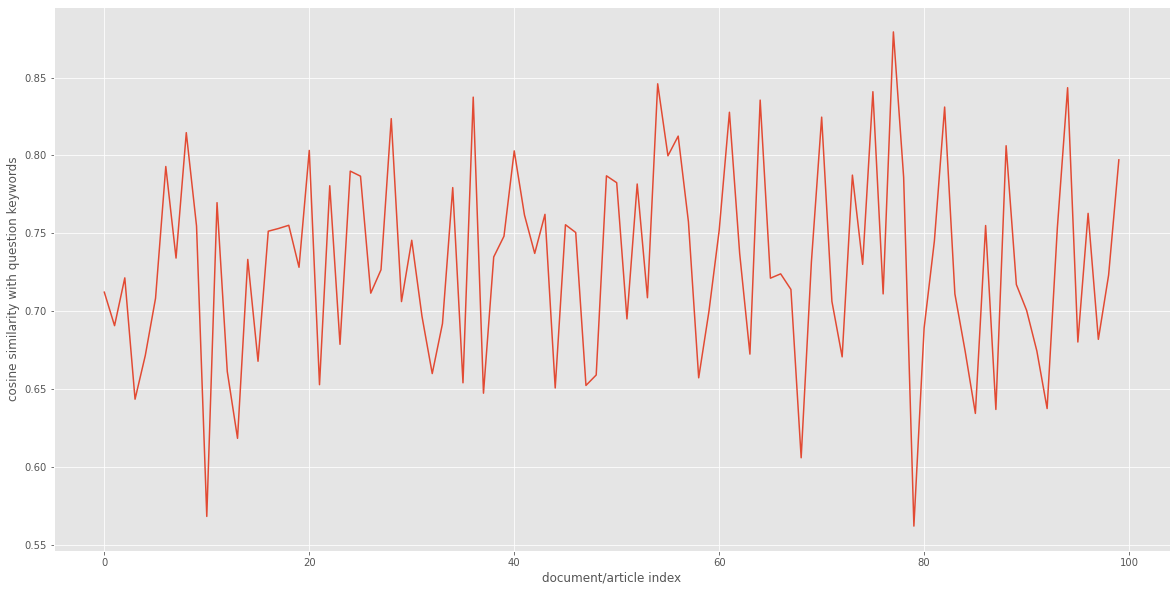

In [28]:
fig = plt.figure(figsize=(20,10))
plt.plot(cosine_similarity[:100])
plt.xlabel('document/article index')
plt.ylabel('cosine similarity with question keywords')

In [29]:
cosine_similarity = cosine_similarity.reshape(-1,)

In [30]:
reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
reqd_idxs

array([ 156, 5369, 7551, 7205,   77])

In [31]:
detect(df_covid_small.iloc[6141]['filtered_body_text'][:])

'en'

In [32]:
cosine_similarity[reqd_idxs]

array([0.89196312, 0.89177695, 0.88193827, 0.88160344, 0.8792951 ])

In [33]:
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['filtered_body_text'][:1000]+"......")
    print("="*140)

Articles for your question: 
Quasispecies and the implications for virus persistence and escape by Esteban Domingo
quasispecies defines a genetic organisation of simple replicons at the population level first proposed by eigen schuster and their colleagues it means that mutant genomes are generated at such high rates that each individual genomic molecule differs on average in one or a few nucleotides from the other molecules and each genomic sequence may deviate from the average or consensus sequence for example in the proposal of the quasispecies model for phage qi it was found that the most abundant genome amounted to 10 -20 of the population this experimental finding agreed with theoretical predictions of eigen and colleagues given the complexity of the qi genome and the mutation rate during its replication since this first proposal that bacteriophage qi replicating in escherichia coli displayed features of a quasispecies a steadily increasing number of rna viruses have been shown t

# Pros and Cons of the approach:    
**Pros**:  
Once the matrix and vector product is constructed, getting cosine similarity between keywords of the question and articles in the corpus is very fast. By just one matrix vector multiplication, we can get cosine similarities between all the articles and keywords of the question. Since sorting the entire vector consisting of cosine similarities is not needed, so use numpy.argpartition which runs in linear time. So, overall this method to get relevant articles according to the question is fast.
  
**Cons**:  
This matrix vector multiplication will become computationally expensive when the size of the matrix grows i.e. if the number of articles in the corpus is very high then matrix vector multiplication will be slow. To solve this we can split the document embedding matrix into multiple document embedding matrices of smaller size and can then compute the matrix vector products simultaneously in parallel. 

# Rahul

<h1>Text Summarization<h1>

In [34]:
import heapq

In [35]:
#function to calculate weighted frequency of all words extracted
def weighted_freq(formatted_article_text,stopwords):
    word_frequencies = {}
    for word in nltk.word_tokenize(formatted_article_text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    return word_frequencies

In [36]:
#function to rank sentences using weighted frequencies
def rank_sentences(sentence_list, word_frequencies):
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
    return sentence_scores

In [37]:
def print_summary(sentences):
    summary = ' '.join(sentences)
    print(summary+'\n')

In [38]:
def generate_summary(doc_indx):
    for idx in doc_indx:
        print("Summary for article: "+ df_covid_small.iloc[idx]['title'])
        #tokenize sentences
        sentence_list = nltk.sent_tokenize(df_covid_small.iloc[idx]['body_text'])
        stopwords = nltk.corpus.stopwords.words('english')
        #get preprocessed articles
        formatted_article_text = df_covid_small.iloc[idx]['filtered_body_text']
        #calculate weighted frequencies
        word_frequencies = weighted_freq(formatted_article_text,stopwords)
        #rank sentences
        sentence_scores = rank_sentences(sentence_list, word_frequencies)
        #generate summary
        summary_sentences = heapq.nlargest(8, sentence_scores, key=sentence_scores.get)
        #print summary
        print_summary(summary_sentences)

Summary for "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes?"

In [39]:
generate_summary(reqd_idxs)

Summary for article: Quasispecies and the implications for virus persistence and escape
Research to better understand quasispecies composition and dynamics is urgently needed, since quasispecies are an important step in the natural history of RNA viruses. Quasispecies structure is an important problem for viral disease control and should not be minimised on account of the indeterminations found when trying to define compositions of mutant spectra. The links between the original theoretical quasispecies concept and viral quasispecies have been discussed in several recent papers Eigen, 1996; . Biological implications of quasispecies extend from viral pathogenesis to the emergence of new viral pathogens (Morse, 1993) . In the extended definition, useful to virology, quasispecies are dynamic distributions of non-identical but closely-related mutant and recombinant viral genomes. One of the most obvious consequences of quasispecies structure is the genetic and antigenic diversification of R

# **K Nearest Neighbours Approach**

In [40]:
class KNN_finder:
    def __init__(self, doc_embeddings, k=5):
        self.doc_embeddings = doc_embeddings
        self.k = k
        
    def update_k(self, k):
        self.k = k
    
    def get_euc_dist(self, query_vec):
        vec_diff = self.doc_embeddings - query_vec
        vec_dist = np.linalg.norm(vec_diff, axis=1)
        return vec_dist
    
    def get_k_nearest(self, query_vec):
        vec_dist = self.get_euc_dist(query_vec)
        reqd_idxs = np.argpartition(vec_dist, 5)[:5]
        reqd_idxs = reqd_idxs[np.argsort(vec_dist[reqd_idxs])]
        return reqd_idxs

In [ ]:
# doc_embeddings = dataset_to_vectors(df_covid_small)

In [41]:
knn = KNN_finder(doc_embeddings)
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
kw_embedding_vec = get_kw_embedding_vec(keywords)
best_5_indx = knn.get_k_nearest(kw_embedding_vec)

In [42]:
best_5_indx

array([5369,  156, 7205, 7551,   77])

In [43]:
for idx in best_5_indx:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Functional genomics as a tool in virus research by Ruchi Ratra, Sunil Lal
The genomics era has revolutionized the biological sciences and has heralded the emergence of new 'omics' methodologies such as transcriptomics (study of the gene expression and expression levels of mRNAs at a given time and condition), proteomics (study of the entire protein content of a cell/tissue under various conditions, their structure and functions), metabolomics (study of the metabolite profi le of different cellular processes), phosphoproteomics (a branch of proteomics that characterizes proteins that are phosphorylated), interactomics/system biology (a science that unifi es transcriptomics, proteomics and metabolomics to look at the organism as a whole) and so on. For years the scientists have followed the reductionist approach, where a single gene and its functions and activities are studied in isolation. Although this branch of experimental biology is indispensable, biological processes are now being 

Summary KNN

In [44]:
generate_summary(best_5_indx)

Summary for article: Functional genomics as a tool in virus research
DNA microarrays, proteomics and bioinformatic analysis are routinely used to analyze changes in host and viral gene and protein expression that occur in a virus infected cell [25] . Functional genomics approach has been routinely applied to study viral replication, gene expression, evolution, and diagnostics and so on. To further characterize this new virus, approximately 1 kb of the unknown virus genome was cloned by physically recovering viral sequences hybridized to individual array elements. This functional genomics approach revealed nearly 100 genes whose absence inhibited or stimulated BMV RNA replication and/or gene expression by 3 -to >25-fold. Whole Functional genomics approach has also been used to study the cellular innate immune response to virus. Functional Genomics on potato virus A was used to map sites essential for virus propagation [45] . Thus functional genomics approach has been successfully used t

# Raj Hansini

# **TF-IDF IMPLEMENTATION**

In [45]:
final_data=df_covid_small.copy(500)
final_data
# calculating the df
#creating a set
DF = {}
#for i in range(len(final_data.iloc[0]['filtered_body_text'])):
tokens =nltk.word_tokenize(final_data.iloc[0]['filtered_body_text'])
tokens[0]
for i in range(len(tokens)):
    temp=tokens[i]
    try:
        DF[temp].add(i)
    except:
        DF[temp] = {i}
#DF

In [46]:
#for i in DF:
#    DF[i]=len(DF[i])
tokens = nltk.word_tokenize(final_data.iloc[0]['filtered_body_text'])
tokens
for i in DF:
    DF[i]=len(DF[i])
#DF


In [47]:
total_vocab=[x for x in DF]
len(total_vocab)

1166

In [48]:
words_freq = words_freq_atleast_2(df_covid_small.iloc[0]['filtered_body_text'])

In [49]:
from nltk import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# computes tf idf similarity between query and documents in dataset with n being max number of retrieved documents
def compute_tf_idf_similarity(query, docs, n,index_store):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(docs)
    query = tfidf_vectorizer.transform([query])
    
    cosine_similarities = linear_kernel(query, tfidf).flatten()
#     related_docs_indices = cosine_similarities.argsort()[:-5:-1]
    related_docs_indices = (-cosine_similarities).argsort()[:n]
    
    res = []
    for i in range(0, len(related_docs_indices)):
        res.append(docs[related_docs_indices[i]])
        index_store.append(related_docs_indices[i])
        
    '''res_df = pd.DataFrame(res, columns=['text'])
    titles = []
    authors = []
    for j in range(0, len(res_df)):
        for i in range(0, len(relevant_corpus)):
            if(relevant_corpus['text'][i] == res_df['text'][j]):
                titles.append(relevant_corpus['title'][i])
                authors.append(relevant_corpus['authors'][i])
                
    res_df['title'] = titles
    res_df['authors'] = authors
    res_df = res_df[["title","authors", "text"]]'''
    return res

In [50]:
# path to corpus of data
#CORONAVIRUS_LIBRARY_PATH = '../input/CORD-19-research-challenge'
# path from which created csv is read
#RELEVANT_PAPERS_PATH = '../input/covid19csv/relevant_papers.csv'
#relevant_corpus = pd.read_csv(RELEVANT_PAPERS_PATH).loc[:]
pd.set_option('max_colwidth', 500)
#df = pd.DataFrame(relevant_corpus)
#docs = df['text'].tolist()
docs = final_data['filtered_body_text'].tolist()
query = "What is the evidence that livestock could be infected (field surveillance, genetic sequencing, receptor binding)? \
Evidence of whether farmers are infected, and whether farmers could have played a role in the origin."
index_store = []
results = compute_tf_idf_similarity(query, docs,5, index_store)
#summaries = summarize_results(results)
#display_output(query, results,summaries)
results
#text sumaarization below.
generate_summary(index_store)# this  will print the answer tot he question

Summary for article: Managing Global Risks: Vietnamese Poultry Farmers and Avian Flu
Farmers have taken H5N1 into account as a poultry disease, but H5N1 is simply one of a number of problems that farmers have to deal with. Interviewed farmers consider that breeding farms are less exposed to diseases affecting poultry in general because they are more isolated and better ventilated, unlike village farms. According to the local veterinarian, all the farmers in the parish were affected to different extents by avian fl u or the resulting consequences. Some farmers believe it is more judicious to rear red chickens rather than white chickens and Peking ducks rather than Muscovy ducks because they are less vulnerable. With this rapid refocusing on the part of the farmers, avian fl u became a relatively classic problem in large part handled as a question of routine. Furthermore, farmers consider Peking ducks to be less sensitive to disease and cold weather than Muscovy ducks (and therefore more

# Kalyani

# Topic Modelling
### Latent Dirichlet Allocation

In [51]:
def get_tokens(filtered_body_text):
    #tokenize the text
    tokens = nltk.word_tokenize(filtered_body_text)
    #print(tokens)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    #print(tokens[:5])
    one_occur = np.array(list(filter(lambda x: x[1] < 5, Counter(tokens).most_common())))[:,0].flatten()
    tokens = list(filter(lambda x: x not in one_occur, tokens))
    #print(tokens)
    return tokens

In [52]:
import gensim


In [53]:
final_df = df_covid_small.head(500).copy()

In [54]:
def array_of_tokens(df):
    processed_docs = []
    l = len(df)
    for i in range(l):
        if i % 100 == 0:
            print("Processing",i,"th of ",l)
        x = get_tokens(df.iloc[i]['filtered_body_text'])
        processed_docs.append(x)
    return processed_docs

In [55]:
def get_dictionary(docs):
    dictionary = gensim.corpora.Dictionary(docs)
    dictionary.filter_extremes(no_below=40, no_above=0.5, keep_n=10000)
    return dictionary
def get_corpus(dictionary):
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    return bow_corpus

In [56]:
def apply_lda(bow_corpus, num_topics, id2word, passes, workers):#, chunksize):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=id2word, passes=passes, workers=workers)#, chunksize = chunksize)
    return lda_model
def print_topics(lda_model):
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))

In [57]:
def get_score_from_keyword(lda_model,keywords):
    scores = []
    bow_vector = dictionary.doc2bow(keywords)
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
        scores.append((score,index))
    return scores

In [58]:
def get_document_topics(lda_model,bow_corpus):
    return [lda_model.get_document_topics(item) for item in bow_corpus]

In [59]:
def index_of_topic_highest_score(scores):
    return scores[0][1]

def get_10_similar_docs(get_document_topics,doc_index):
    similar_docs = []
    for i,doc in enumerate(get_document_topics):
        for tup in doc:
            if tup[0] == doc_index:
                similar_docs.append((tup[1],i))
    similar_docs.sort(reverse = True)
    return similar_docs[:10]

def display_10_docs(similar_docs):
    for doc in similar_docs:
        print(df_covid_small.iloc[doc[1]]['title'])
        print(df_covid_small.iloc[doc[1]]['body_text'][:1000])
        print("===============================================================================================================")

In [60]:
#driver
processed_docs = array_of_tokens(final_df)

# model = apply_lda(corpus,10,dictionary,2,5,100)
# print_topics(model)
# scores = get_score_from_keyword(model,keywords)
# print(scores)


Processing 0 th of  500
Processing 100 th of  500
Processing 200 th of  500
Processing 300 th of  500
Processing 400 th of  500


In [61]:
dictionary = get_dictionary(processed_docs)
corpus = get_corpus(dictionary)

In [62]:
model = apply_lda(corpus,10,dictionary,2,10)
print_topics(model)
question = "What do we know about corona virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
scores = get_score_from_keyword(model,keywords)
print(scores)

Topic: 0 
Words: 0.047*"virus" + 0.044*"cell" + 0.043*"protein" + 0.020*"human" + 0.019*"gene" + 0.013*"strain" + 0.013*"viral" + 0.012*"disease" + 0.012*"result" + 0.012*"effect"
Topic: 1 
Words: 0.078*"cell" + 0.031*"patient" + 0.020*"mouse" + 0.017*"result" + 0.015*"protein" + 0.014*"response" + 0.014*"clinical" + 0.014*"1" + 0.013*"treatment" + 0.013*"day"
Topic: 2 
Words: 0.072*"health" + 0.020*"system" + 0.018*"public" + 0.017*"disease" + 0.017*"risk" + 0.017*"state" + 0.016*"result" + 0.015*"country" + 0.015*"individual" + 0.015*"level"
Topic: 3 
Words: 0.022*"cell" + 0.021*"data" + 0.019*"group" + 0.017*"model" + 0.017*"disease" + 0.016*"virus" + 0.016*"day" + 0.015*"2" + 0.015*"analysis" + 0.014*"influenza"
Topic: 4 
Words: 0.104*"patient" + 0.028*"case" + 0.022*"covid-19" + 0.018*"disease" + 0.018*"drug" + 0.018*"clinical" + 0.018*"treatment" + 0.017*"2" + 0.017*"hospital" + 0.016*"1"
Topic: 5 
Words: 0.061*"virus" + 0.030*"cell" + 0.028*"protein" + 0.018*"1" + 0.017*"mouse" 

In [63]:
doc_topics = get_document_topics(model,corpus)
relevant_docs = get_10_similar_docs(doc_topics,index_of_topic_highest_score(scores))
print(relevant_docs)
display_10_docs(relevant_docs)

[(0.9980214, 246), (0.9968296, 149), (0.9946735, 236), (0.9916648, 198), (0.9907197, 127), (0.99032086, 157), (0.99010766, 488), (0.98702455, 172), (0.9808469, 370), (0.96976686, 181)]
Virus survey in populations of two subspecies of bent-winged bats (Miniopterus orianae bassanii and oceanensis) in south-eastern Australia reveals a high prevalence of diverse herpesviruses
Historically, infectious diseases were believed to be of minimal significance in species population declines. An International Union for Conservation of Nature (IUCN) report listed 833 species extinctions over the past 500 years and attributed only 3.7% of these to infectious disease [1] . This low percentage of extinctions caused by infectious disease may be partly due to the past use of less sophisticated diagnostic techniques to detect infectious agents, as it is now becoming apparent that the effects of urbanization, human population growth, altered land use, deforestation, reduced biodiversity and global trade ar

In [64]:
generate_summary(list(map(lambda x: x[1], relevant_docs)))

Summary for article: Virus survey in populations of two subspecies of bent-winged bats (Miniopterus orianae bassanii and oceanensis) in south-eastern Australia reveals a high prevalence of diverse herpesviruses
While Victorian southern bent-winged bats did have a higher prevalence of infection than eastern bent-winged bats, the opposite was true for the South Australian bats. The eastern bent-winged bats from Christmas Hills contained the largest number of different herpesviruses (four), while the southern bent-winged bats from Allansford only contained one herpesvirus. All the dead bats tested negative for herpesvirus, except for two southern bent-winged bats from Naracoorte, one from a liver sample and another from a lung sample. Five of the bent-winged bat viruses detected in this study were betaherpesviruses, while one virus, found only in juvenile Naracoorte bats, was a gammaherpesvirus, (N7050-like). This was observed in bats from Naracoorte (southern bent-winged bat), but not th

Inactivated IBV lacking the S1 glycoprotein did not induce protection in the trachea of immunized chickens whereas whole inactivated IBV protected chickens against virulent challenge [9] . In there separate experiments chickens were immunized with 50 ~tg of immunoaffinity purified $1, N and M proteins and inactivated and live N1/62 virus at four weekly intervals. Our results showed that the S 1 glycoprotein of IBV induces protective immunity against IBV-infection whereas neither the N protein nor the M glycoprotein induced any level of protection. Protection induced by the purified S1 glycoprotein was complete and prevented replication of the challenge virus in trachea and kidney tissues which are the target organs for IBV replication. The ELISA antibodies were detected in all chickens immunized with the N antigen four weeks following secondary immunization (P ~< 0.001) ( Table 2) . In this study protection induced by the purified S1 glycoprotein and inactivated IBV did not correlate w

# Pulaksh


https://github.com/UKPLab/sentence-transformers

In [65]:
pip install -U sentence-transformers


     |████████████████████████████████| 55 kB 1.8 MB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-py3-none-any.whl size=74030 sha256=606bac4aea1155470e2af4db05efb685b67b40401028114268581c072fddf567
  Stored in directory: /root/.cache/pip/wheels/71/eb/84/05830bceaeef549ceb0257c6797254173e197e971b3f911ee4
Successfully built sentence-transformers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [66]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

100%|██████████| 405M/405M [02:40<00:00, 2.53MB/s] 


In [67]:
final_df = df_covid_small.head(500).copy()

In [70]:
np.array(model.encode(['a'])).shape

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


(1, 768)

In [71]:
np.array(model.encode(nltk.sent_tokenize(final_df.iloc[0]['filtered_body_text']))).shape

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


(1, 768)

Output of next cell is hidden for readability as it's very long.

In [ ]:
doc_embeddings = np.zeros((len(final_df),768))
norms_doc_embeddings = np.zeros((len(final_df),1))
for i in range(len(final_df)):
    if i % 100 == 0:
        print("working on "+str(i)+"th document")
    doc_embedding_vec = np.array(model.encode(nltk.sent_tokenize(final_df.iloc[i]['filtered_body_text'])))
    doc_embedding_vec = doc_embedding_vec.sum(axis=0)
    doc_embedding_vec /= len(nltk.sent_tokenize(final_df.iloc[i]['filtered_body_text']))
    norms_doc_embeddings[i,:] = np.sqrt(np.dot(doc_embedding_vec,doc_embedding_vec.T))
    doc_embeddings[i,:] = doc_embedding_vec


In [74]:
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
ques_embedding_vec = np.array(model.encode([question]))
norm_ques_embedding = np.sqrt(np.dot(ques_embedding_vec, ques_embedding_vec.T))

Batches: 100%|██████████| 1/1 [00:00<00:00, 61.75it/s]


In [75]:
norm_prods = norms_doc_embeddings * norm_ques_embedding
dot_prod = np.dot(doc_embeddings, ques_embedding_vec.T)
cosine_similarity = dot_prod / norm_prods

In [76]:
cosine_similarity = cosine_similarity.reshape(-1,)
reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
reqd_idxs

array([311,  80, 103, 411,  95])

In [77]:
print("Articles for your question: ")
for idx in reqd_idxs:
    print(final_df.iloc[idx]['title']+" by "+ final_df.iloc[idx]['authors'])
    print(final_df.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Articles for your question: 
Thermal-induced unfolding-refolding of a nucleocapsid COVN protein by Warin Rangubpit, Pornthep Sompornpisut, R Pandey
W, 110 Y, 224 L, 374 P even at high temperatures.
CoVID-19 pandemic is attracting unprecedented attention [1] [2] [3] [4] [5] in investigating the corona virus and its constituents. Corona virus involves a number of proteins, RNA and a huge list of crowded inter-and intra-cellular constituents in its assembly and replication. In an initial investigation even with a coarse-grained computer simulation model it is not feasible to consider all constituents that are involved in its assembly and replication. We examine the structural dynamics of a nucleocapsid (COVN) protein [6] consisting of 422 residues which plays a critical role in packaging the viral genome RNA into ribonucleocapsid and virion assembly [7] [8] [9] . For the sake of simplicity and to develop a clear understanding of the basic nature of the conformational evolution, it would b

Summary for What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes?

In [79]:
generate_summary(reqd_idxs)

Summary for article: Thermal-induced unfolding-refolding of a nucleocapsid COVN protein
The radius of gyration increases on raising the temperature, first monotonically from a minimum in its native state to a maximum value. The effective dimension begin to reduce with increasing the temperature further as the protein conformation approaches a tenuous structure, i.e. A number of local and global physical quantities such as radius of gyration, root mean square displacement of the center of mass, structure factor, contact map, etc. At low temperatures (T=0.010 -0.015), the radius of gyration remains almost constant with its lowest magnitude (Rg  22.5) in its native phase. First, we notice that the number of residues (Nr) within the range of interaction of each residues along the backbone, is higher at lower temperatures. While most segmental folds disappear in denatured phase while some persist even at a very high temperature (see below). 367 T-380 A (along with other segments with compa

In [80]:
def compute_cosine_get_idxs(norms_doc_embeddings, norm_ques_embedding, ques_embedding_vec, doc_embeddings):
    norm_prods = norms_doc_embeddings * norm_ques_embedding
    dot_prod = np.dot(doc_embeddings, ques_embedding_vec.T)
    cosine_similarity = dot_prod / norm_prods
    cosine_similarity = cosine_similarity.reshape(-1,)
    reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
    reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
    return reqd_idxs

In [81]:
question = "What about Animal host and any evidence of continued spill over to humans, Socioeconomic and behavioral risk factors for this spill over?"
ques_embedding_vec = np.array(model.encode([question]))
norm_ques_embedding = np.sqrt(np.dot(ques_embedding_vec, ques_embedding_vec.T))
reqd_idxs = compute_cosine_get_idxs(norms_doc_embeddings, norm_ques_embedding, ques_embedding_vec, doc_embeddings)
print("Articles for your question: ")
for idx in reqd_idxs:
    print(final_df.iloc[idx]['title']+" by "+ final_df.iloc[idx]['authors'])
    print(final_df.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Batches: 100%|██████████| 1/1 [00:00<00:00, 66.04it/s]

Articles for your question: 
Phylogeny and Origins of Hantaviruses Harbored by Bats, Insectivores, and Rodents by Wen-Ping Guo, Xian-Dan Lin, Wen Wang, Jun-Hua Tian, Mei-Li Cong, Hai-Lin Zhang, Miao-Ruo Wang, Run-Hong Zhou, Jian-Bo Wang, Ming-Hui Li, Jianguo Xu, Edward Holmes, Yong-Zhen Zhang
Emerging infectious diseases have a substantial and ongoing impact on public health and agricultural production [1] [2] [3] . Over half of the currently recognized pathogens are zoonotic, and nearly all of the most important human pathogens are either zoonotic or originated as zoonoses before adapting to human transmission [4, 5] . Hence, wildlife species play a key role in disease emergence by providing a ''zoonotic pool'' from which previously unknown pathogens may emerge [1] . A major goal of infectious disease research is therefore to characterize those unknown pathogens circulating in animal host reservoirs before they emerge in human populations [6, 7] .
Hantaviruses (genus Hantavirus, famil

Summary for What about Animal host and any evidence of continued spill over to humans, Socioeconomic and behavioral risk factors for this spill over?

In [82]:
generate_summary(reqd_idxs)

Summary for article: Phylogeny and Origins of Hantaviruses Harbored by Bats, Insectivores, and Rodents
Here, we describe four novel hantaviruses (Huangpi virus, Lianghe virus, Longquan virus, and Yakeshi virus) that were sampled from bats and shrews in China. One notable feature of our phylogenetic analysis was the basal position of phylogroup I viruses in the S segment tree but of phylogroup II viruses in the M segment. Our analysis also suggests that hantaviruses might have first appeared in bats or insectivores, before spreading to rodents, even though rodents are currently the best documented hosts of hantaviruses. Accordingly, we propose naming these four novel hantaviruses as Huangpi virus (HUPV), Lianghe virus (LHEV) Longquan virus (LQUV), and Yakeshi virus (YKSV), reflecting their geographic origins. In the S segment tree (Figure 2A ), all known hantaviruses including the viruses identified in bats and insectivores could be placed into four well supported 'phylogroups'. In the 